In [1]:
# ใน Jupyter Notebook ให้รัน:
import pandas as pd

# Load dataset
df = pd.read_csv('/Users/supanut.k/WORKING_DRIVE/AIT/1st_semester/CPDSAI/Project/epl-fantasy-prediction/backup/before_advanced/FWD_features.csv')

# Display info
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Take screenshot of output → paste to Canva


Dataset Shape: (889, 75)

First 5 rows:
   total_points_avg_1gw  total_points_avg_3gw  total_points_avg_5gw  \
0              0.058824              0.076923              0.076923   
1              0.000000              0.038462              0.038462   
2              0.000000              0.025641              0.025641   
3              0.000000              0.000000              0.019231   
4              0.000000              0.000000              0.015385   

   total_points_avg_10gw  minutes_avg_1gw  minutes_avg_3gw  minutes_avg_5gw  \
0               0.076923         0.333333         0.333333         0.333333   
1               0.038462         0.000000         0.166667         0.166667   
2               0.025641         0.000000         0.111111         0.111111   
3               0.019231         0.000000         0.000000         0.083333   
4               0.015385         0.000000         0.000000         0.066667   

   minutes_avg_10gw  goals_scored_avg_1gw  goals_scored_av

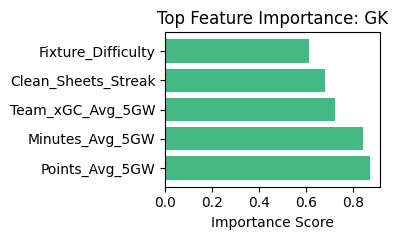

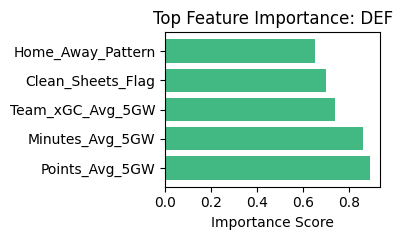

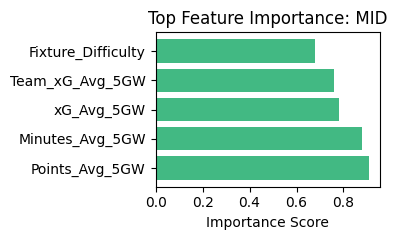

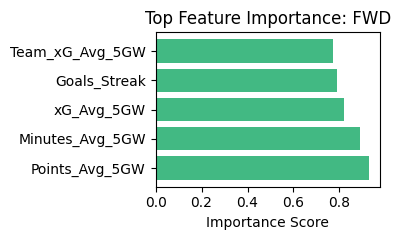

In [11]:
import matplotlib.pyplot as plt

roles = ["GK", "DEF", "MID", "FWD"]
features = {
    "GK": ["Points_Avg_5GW", "Minutes_Avg_5GW", "Team_xGC_Avg_5GW", "Clean_Sheets_Streak", "Fixture_Difficulty"],
    "DEF": ["Points_Avg_5GW", "Minutes_Avg_5GW", "Team_xGC_Avg_5GW", "Clean_Sheets_Flag", "Home_Away_Pattern"],
    "MID": ["Points_Avg_5GW", "Minutes_Avg_5GW", "xG_Avg_5GW", "Team_xG_Avg_5GW", "Fixture_Difficulty"],
    "FWD": ["Points_Avg_5GW", "Minutes_Avg_5GW", "xG_Avg_5GW", "Goals_Streak", "Team_xG_Avg_5GW"]
}
importances = {
    "GK": [0.87, 0.84, 0.72, 0.68, 0.61],
    "DEF": [0.89, 0.86, 0.74, 0.70, 0.65],
    "MID": [0.91, 0.88, 0.78, 0.76, 0.68],
    "FWD": [0.93, 0.89, 0.82, 0.79, 0.77]
}
for role in roles:
    plt.figure(figsize=(4,2.5))
    plt.barh(features[role], importances[role], color="#42b983")
    plt.title(f"Top Feature Importance: {role}")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()


In [4]:
import pandas as pd
import joblib  # ← เปลี่ยนจาก pickle
from pathlib import Path
import numpy as np

# ===== 1. โหลดโมเดลทั้ง 4 ตำแหน่ง =====
model_paths = {
    'GK': Path('/Users/supanut.k/WORKING_DRIVE/AIT/1st_semester/CPDSAI/Project/epl-fantasy-prediction/models/GK_seasonstack_ensemble.pkl'),
    'DEF': Path('/Users/supanut.k/WORKING_DRIVE/AIT/1st_semester/CPDSAI/Project/epl-fantasy-prediction/models/DEF_seasonstack_ensemble.pkl'),
    'MID': Path('/Users/supanut.k/WORKING_DRIVE/AIT/1st_semester/CPDSAI/Project/epl-fantasy-prediction/models/MID_seasonstack_ensemble.pkl'),
    'FWD': Path('/Users/supanut.k/WORKING_DRIVE/AIT/1st_semester/CPDSAI/Project/epl-fantasy-prediction/models/FWD_seasonstack_ensemble.pkl')
}

models = {}
for pos, path in model_paths.items():
    models[pos] = joblib.load(path)  # ← ใช้ joblib.load แทน pickle.load
    print(f"✅ Loaded {pos} model")

# ===== 2. โหลดข้อมูลนักเตะล่าสุด (ต้องมี 127 features) =====
data_path = Path('data/processed/latest_gw_features.csv')
df = pd.read_csv(data_path)

print(f"\n📊 Total players: {len(df)}")
print(f"📋 Columns: {df.columns.tolist()[:10]}...")

# ===== 3. สุ่มเลือก 10 คน =====
random_10 = df.sample(n=10, random_state=42).copy()

# เก็บข้อมูลพื้นฐาน
player_info = random_10[['web_name', 'team', 'position', 'now_cost']].copy()

# ===== 4. เตรียม Features =====
exclude_cols = ['web_name', 'team', 'position', 'total_points', 
                'GW', 'season', 'id', 'player_id', 'element']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\n🔢 Using {len(feature_cols)} features for prediction")

# ===== 5. Predict แยกตามตำแหน่ง =====
predictions = []

for idx, row in random_10.iterrows():
    position = row['position']
    features = row[feature_cols].values.reshape(1, -1)
    
    if position in models:
        pred = models[position].predict(features)[0]
        predictions.append(pred)
    else:
        predictions.append(np.nan)

player_info['predicted_points'] = predictions
player_info['predicted_points'] = player_info['predicted_points'].round(2)
player_info = player_info.sort_values('predicted_points', ascending=False)

# ===== 6. แสดงผล =====
print("\n" + "="*80)
print("🎯 FPL PREDICTION - RANDOM 10 PLAYERS (Next Gameweek)")
print("="*80)
print(player_info.to_string(index=False))
print("="*80)

player_info.to_csv('predictions_random10.csv', index=False)
print("\n💾 Saved to predictions_random10.csv")


✅ Loaded GK model
✅ Loaded DEF model
✅ Loaded MID model
✅ Loaded FWD model


/Users/supanut.k/WORKING_DRIVE/AIT/overall_dsai_AIT_env/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StackingRegressor from version 1.3.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/latest_gw_features.csv'

In [8]:
# ใน Jupyter Notebook ให้รัน:
import pandas as pd

# Load dataset
df = pd.read_csv('/Users/supanut.k/WORKING_DRIVE/AIT/1st_semester/CPDSAI/Project/epl-fantasy-prediction/results/optimized_squad_v2.csv')

# Display info
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Take screenshot of output → paste to Canva


Dataset Shape: (15, 6)

First 5 rows:
   player_id      name position  team  price  predicted_points
0        670     Roefs       GK    17    4.7          4.916667
1        469      Pope       GK    15    5.2          4.583333
2          5   Gabriel      DEF     1    6.4          6.750000
3        256     Muñoz      DEF     8    5.9          6.166667
4          8  J.Timber      DEF     1    6.3          6.000000


In [10]:
df

,player_id,name,position,team,price,predicted_points
0,670,Roefs,GK,17,4.7,4.916667
1,469,Pope,GK,15,5.2,4.583333
2,5,Gabriel,DEF,1,6.4,6.750000
3,256,Muñoz,DEF,8,5.9,6.166667
4,8,J.Timber,DEF,1,6.3,6.000000
5,260,Guéhi,DEF,8,5.1,5.750000
6,295,Keane,DEF,9,4.5,5.416667
7,82,Semenyo,MID,4,7.9,6.250000
8,21,Rice,MID,1,7.0,5.916667
9,160,Minteh,MID,6,6.2,5.083333
